In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

In [64]:
class SOM:
    def __init__(self, x, y, input_dim, learning_rate=0.5, radius=2.0):
        self.x = x
        self.y = y
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.radius = radius
        self.weights = np.random.random((x, y, input_dim))
        self.labels_map = np.empty((x, y), dtype=object)

    def _euclidean_distance(self, x, y):
        return np.linalg.norm(x - y)

    def find_bmu(self, input_vector):
        bmu = None
        min_dist = float('inf')
        for i in range(self.x):
            for j in range(self.y):
                w = self.weights[i, j]
                dist = self._euclidean_distance(w, input_vector)
                if dist < min_dist:
                    min_dist = dist
                    bmu = (i, j)
        return bmu

    def update_weights(self, input_vector, bmu, iteration, max_iterations):
        decay_lr = self.learning_rate * (1 - iteration / max_iterations)
        decay_radius = self.radius * (1 - iteration / max_iterations)
        for i in range(self.x):
            for j in range(self.y):
                dist_to_bmu = self._euclidean_distance(np.array([i, j]), np.array(bmu)) # This is the distance between indexes
                if dist_to_bmu <= decay_radius:
                    influence = np.exp(-dist_to_bmu ** 2 / (2 * decay_radius ** 2))
                    self.weights[i, j] += decay_lr * influence * (input_vector - self.weights[i, j])

    def train(self, data, labels, num_iterations):
        for iteration in range(num_iterations):
            input_vector = data[np.random.randint(0, data.shape[0])]
            bmu = self.find_bmu(input_vector)
            self.update_weights(input_vector, bmu, iteration, num_iterations)
        self._assign_labels(data, labels)

    def _assign_labels(self, data, labels):
        mapping = {}
        for i, input_vector in enumerate(data):
            bmu = self.find_bmu(input_vector)
            if bmu not in mapping:
                mapping[bmu] = []
            mapping[bmu].append(labels[i])
        for bmu, label_list in mapping.items():
            self.labels_map[bmu] = Counter(label_list).most_common(1)[0][0]

    def predict(self, data):
        predictions = []
        for input_vector in data:
            bmu = self.find_bmu(input_vector)
            predictions.append(self.labels_map[bmu])
        return np.array(predictions)
    
    def av_dist_to_bmu(self, data):
        distances = []
        for input_vector in data:
            bmu = self.find_bmu(input_vector)
            # print(self.weights[bmu])
            # print(input_vector)
            distances.append(self._euclidean_distance(self.weights[bmu], input_vector))
        return sum(distances) / len(distances)

    def visualize_labels(self):
        plt.figure(figsize=(8, 8))
        for i in range(self.x):
            for j in range(self.y):
                if self.labels_map[i, j] is not None:
                    plt.text(i + 0.5, j + 0.5, str(self.labels_map[i, j]), ha='center', va='center',
                             bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))
        plt.xlim(0, self.x)
        plt.ylim(0, self.y)
        plt.gca().invert_yaxis()
        plt.title("SOM Grid with Labels")
        plt.grid(True)
        plt.show()

    def visualize_weights(self):
        plt.imshow(self.weights.reshape(self.x, self.y, self.input_dim), interpolation="none")
        plt.title("SOM Grid")
        plt.show()

In [65]:
# Prepare data
iris_df = pd.read_csv('iris.csv')
features = iris_df.iloc[:, :-1].values
labels = iris_df.iloc[:, -1].values
features_normalized = (features - features.min(axis=0)) / (features.max(axis=0) - features.min(axis=0))
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.4, random_state=42)


# Initialize and train SOM
som = SOM(x=5, y=5, input_dim=X_train.shape[1], learning_rate=0.5, radius=8)
som.train(X_train, y_train, num_iterations=2000)

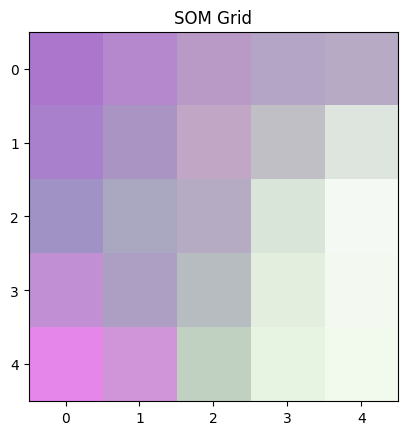

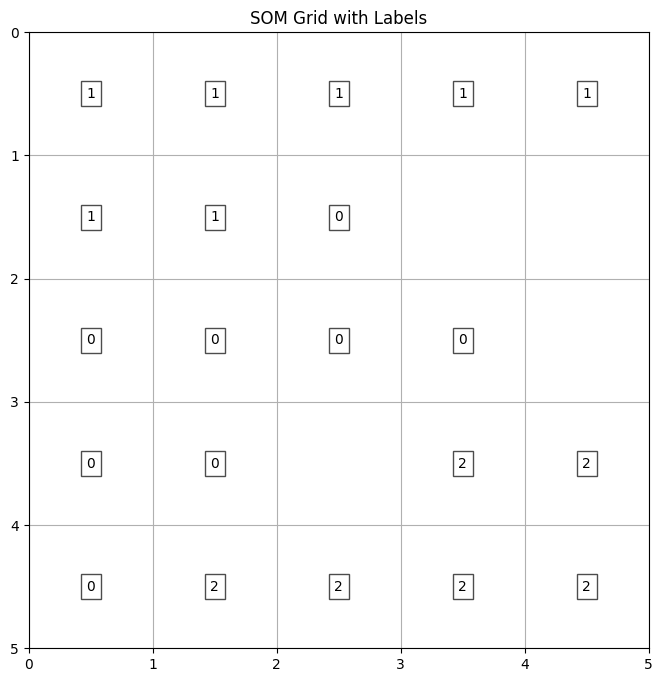

In [66]:
# Visualize weights and labels assigned to neurons
som.visualize_weights()
som.visualize_labels()

In [67]:
# Make predictions and calculate accuracy
y_pred = som.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")


print(f"Average distance: {som.av_dist_to_bmu(X_test)}")


Accuracy: 86.67%
Average distance: 0.11543217443208799
